# Implementación Manual de KNN

Implementación de algoritmo de knn en imágenes con puro numpy.

Comenzamos importando las librerías que vamos a utilizar

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import randint
%matplotlib inline

## Obteniendo la información

Antes de poder comenzar a entrenar el modelo tenemos que obtener la información de nuestro dataset. En nuestro caso vamos a usar el dataset cifar 10 que obtuvimos de http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz 

Estos archivos vienen en un pickle que simplemente guardan la información para poder usarla después en python, así que ahora vamos a importar unos de los batches

In [2]:
def unpickle(file_path):
    import pickle
    with open(file_path, 'rb') as file:
        data = pickle.load(file, encoding='bytes')
    return data

In [3]:
batch1 = unpickle('../datasets/cifar-10-batches-py/data_batch_1')
test_batch = unpickle('../datasets/cifar-10-batches-py/test_batch')

In [4]:
print(batch1.keys())
print(test_batch.keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [5]:
print('Example of label, data and filename from batch1')
print(batch1[b'labels'][0])
print(batch1[b'data'][0])
print(batch1[b'filenames'][0])

Example of label, data and filename from batch1
6
[ 59  43  50 ... 140  84  72]
b'leptodactylus_pentadactylus_s_000004.png'


La label está en número entonces vamos a importar los meta datos

In [6]:
meta_data = unpickle('../datasets/cifar-10-batches-py/batches.meta')
print(meta_data)

{b'num_cases_per_batch': 10000, b'label_names': [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck'], b'num_vis': 3072}


**Por simplicidad vamos a guardar la información en nuevas variables que sean data y labels**

In [7]:
train_data = batch1[b'data']
train_labels = np.array(batch1[b'labels'])
test_data = test_batch[b'data']
test_labels = np.array(test_batch[b'labels'])
label_names = meta_data[b'label_names']

## Revisando información

Ahora que ya tenemos los datos hay que ver cómo se ven, para esto vamos a reacomodar los datos en modo imagen y mostrarlas con matplotlib

In [8]:
def np_array_to_image(arr):
    image = np.reshape(arr, (3, 32, 32))
    image = np.transpose(image, (1, 2, 0))
    return image

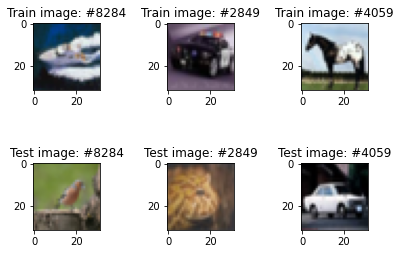

In [9]:
random_nums = [randint(0, 10000), randint(0, 10000), randint(0, 10000)]
plt.figure()
for i in range(3):
    a = plt.subplot(2, 3, i+1)
    plt.imshow(np_array_to_image(train_data[random_nums[i]]))
    a.set_title(f'Train image: #{random_nums[i]}')
    b = plt.subplot(2, 3, i+4)
    plt.imshow(np_array_to_image(test_data[random_nums[i]]))
    b.set_title(f'Test image: #{random_nums[i]}')
plt.subplots_adjust(wspace=1, hspace=0.8)

## Programación del modelo

Utilizando una clase de python vamos a entrenar un modelo de KNN

In [10]:
class Knn:
    def __init__(self):
        self.data = None
        self.labels = None
    
    def train(self, train_data, train_labels):
        if self.data is not None and self.labels is not None:
            self.data = np.append(self.data, train_data, axis=0)
            self.labels = np.append(self.labels, train_labels)
        else:
            self.data = train_data
            self.labels = train_labels
            
    def get_train_image(self, index):
        if self.data is not None and self.labels is not None:
            return self.data[index]
        return None
        
    
    def calculate_euclidian_distance(self, a, b):
        return np.sqrt(np.sum((a-b)**2, axis=0))
    
    def predict(self, data, k):
        errors = np.array([self.calculate_euclidian_distance(entry, data) for entry in self.data])
        dtype = [('id_original', int),('error', float), ('label', int)]
        err_label_arr = np.array([(i, errors[i], self.labels[i]) for i in range(len(errors))], dtype=dtype)
        sorted_arr = np.sort(err_label_arr, order='error')
        res = [{'id': entry[0], 'error': entry[1], 'label':entry[2]} for entry in sorted_arr[:k]]
        return res 
    
    def __repr__(self):
        if self.data is not None and self.labels is not None:
            return f'Data: {self.data.shape}\nLabels: {self.labels.shape}'
        return 'No data in the model'

**Instanciamos el modelo y lo entrenamos con la información**

In [11]:
my_knn = Knn()
my_knn.train(train_data, train_labels)
print(my_knn)

Data: (10000, 3072)
Labels: (10000,)


## Predicciones

Para probar el modelo lo que vamos a hacer es correr predicciones random con diferentes valores de k. En las imágenes de abajo se pude ver la imagen de prueba y las imágenes que el modelo cree que son las más cercanas junto con sus labels y el error

In [18]:
random_num = randint(0,10000)
random_k = randint(1, 5)
random_test_image = test_data[random_num]
random_image_label = test_labels[random_num]
prediction_results = my_knn.predict(random_test_image, random_k)

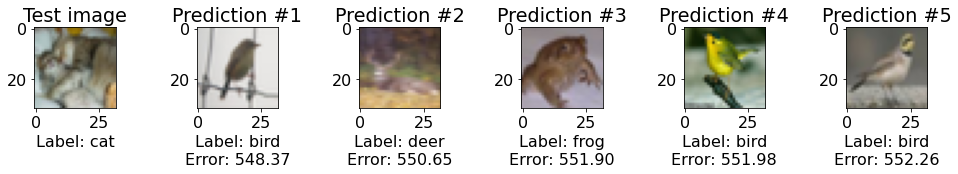

In [19]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(16,10))
a = plt.subplot(1, random_k + 1, 1)
plt.imshow(np_array_to_image(test_data[random_num]))
a.set_title(f'Test image')
plt.xlabel(f'Label: {label_names[test_labels[random_num]].decode()}')
for i in range(random_k):
    prediction = prediction_results[i]
    prediction_id = prediction['id']
    prediction_error = prediction['error']
    prediction_label = label_names[prediction['label']].decode()
    a = plt.subplot(1, random_k + 1, i+2)
    plt.imshow(np_array_to_image(my_knn.get_train_image(prediction_id)))
    a.set_title(f'Prediction #{i + 1}')
    plt.xlabel(f'Label: {prediction_label}\nError: {prediction_error:.2f}')
plt.subplots_adjust(wspace=1, hspace=0.8)